<center><h1>$$\text{** Imports & Config **}$$</h1></center>

In [1]:
!pip install -q torchmetrics -U mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 13.3 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, ConcatDataset, random_split

import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import torchvision
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from timeit import default_timer as timer
import random
from pathlib import Path

print(torch.__version__)

2.8.0+cu126


In [3]:
RANDOM_SEED = 42
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

<center><h1>$$\text{** Datasets **}$$</h1></center>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import shutil

print(os.getcwd())

drive_data_path = f"{os.getcwd()}/drive/MyDrive/Colab Notebooks/data"

print(os.listdir(drive_data_path))

/content
['pretrainedModel.pth', 'TrainingSet_json', 'TestSet_json', 'ImprovementSet', 'TrainingSet', 'TestSet']


In [7]:
# Picture dimensions are: 640 x 480 (W x H)
transform = transforms.Compose([
    transforms.Resize((96, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
training_set = datasets.ImageFolder(
    root=f"{drive_data_path}/TrainingSet/TrainingSet",
    transform=transform
)
print("Train: ", len(training_set), ",\t\t classes: ", training_set.class_to_idx)

validation_set = datasets.ImageFolder(
    root=f"{drive_data_path}/ImprovementSet/ImprovementSet/ImprovementSet",
    transform=transform
)
print("Validation: ", len(validation_set), ",\t classes: ", validation_set.class_to_idx)

test_set = datasets.ImageFolder(
    root=f"{drive_data_path}/TestSet/TestSet",
    transform=transform
)
print("Test: ", len(test_set), ",\t\t classes: ", test_set.class_to_idx)

Train:  1704 ,		 classes:  {'Closed': 0, 'Opened': 1}
Validation:  4103 ,	 classes:  {'Closed': 0, 'Opened': 1}
Test:  4232 ,		 classes:  {'Closed': 0, 'Opened': 1}


In [9]:
dict(Counter(training_set.targets))

{0: 880, 1: 824}

In [10]:
# Different split proportion
full_dataset = ConcatDataset([training_set, validation_set, test_set])
print("Full: ", len(full_dataset))

Full:  10039


In [11]:
total_size = len(full_dataset)

train_size = int(0.6 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

print(train_size, val_size, test_size)

6023 1505 2511


In [12]:
training_set, validation_set, test_set = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator(device="cpu")
)
print("Train: ", len(training_set))
print("Validation: ", len(validation_set))
print("Test: ", len(test_set))

Train:  6023
Validation:  1505
Test:  2511


In [13]:
train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
def count_targets(dataset):
  all_targets = []
  for i in dataset.indices:
      # Index of a dataset that contains i
      dataset_idx = 0
      while i >= len(full_dataset.datasets[dataset_idx]):
          i -= len(full_dataset.datasets[dataset_idx])
          dataset_idx += 1
      label = full_dataset.datasets[dataset_idx].targets[i]
      all_targets.append(label)

  return dict(Counter(all_targets)), all_targets

train_count, train_targets = count_targets(training_set)
print("Train: ", train_count)

val_count, val_targets = count_targets(validation_set)
print("Validation: ", val_count)

test_count, test_targets = count_targets(test_set)
print("Test: ", test_count)

Train:  {0: 2989, 1: 3034}
Validation:  {0: 759, 1: 746}
Test:  {0: 1254, 1: 1257}


<center><h1>$$\text{** Visualize Data **}$$</h1></center>

Image shape:  torch.Size([3, 96, 128])
Permuted image shape:  torch.Size([96, 128, 3])
Label:  0


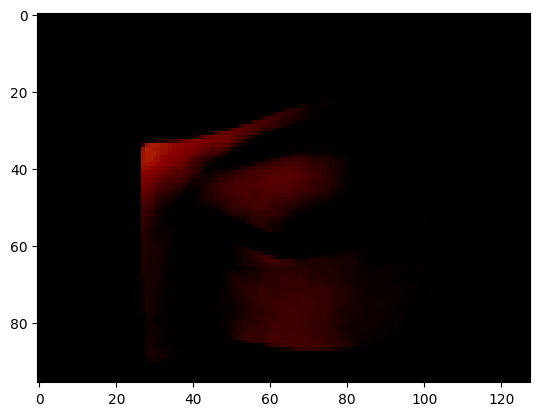

In [15]:
image, label = training_set[0]
permuted_image = image.permute(1, 2, 0)
print("Image shape: ", image.shape)
print("Permuted image shape: ", permuted_image.shape)
print("Label: ", label)

# Colour channel needs to be the last argument when printing
plt.imshow(permuted_image)

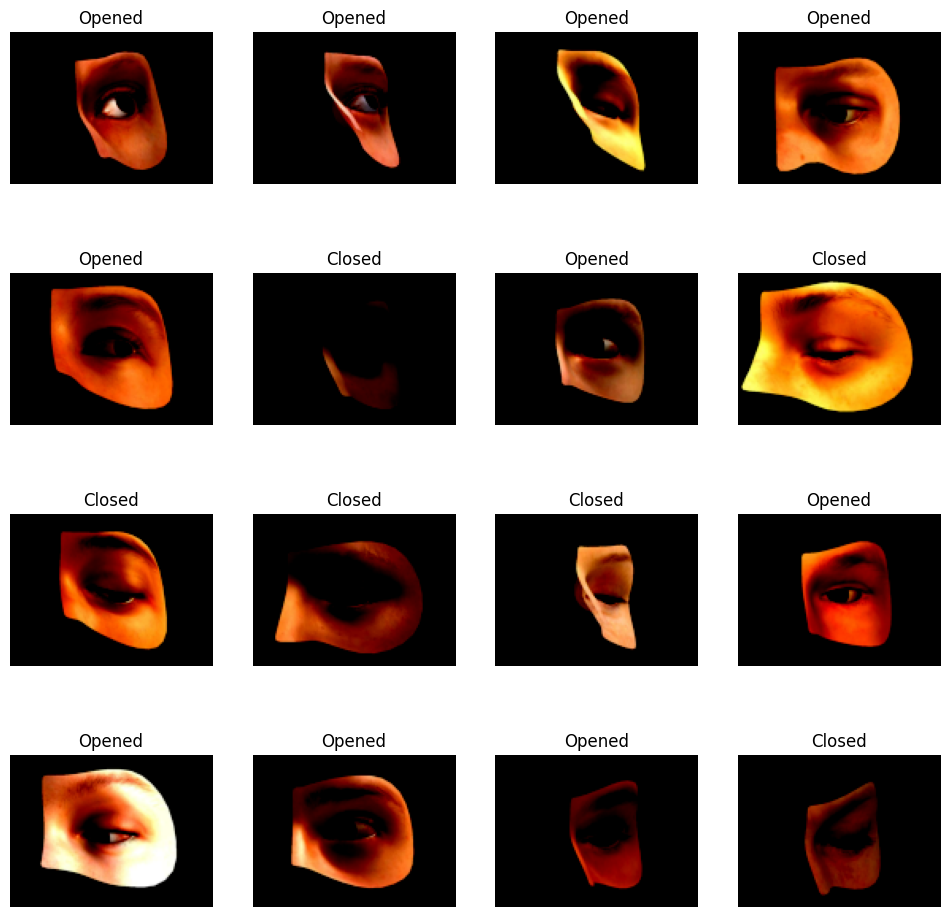

In [16]:
torch.manual_seed(RANDOM_SEED)
fig = plt.figure(figsize=(12, 12))

class_names = ['Closed', 'Opened']

rows, cols = 4, 4

for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(training_set), size=[1]).item()
  img, label = training_set[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))
  plt.title(class_names[label])
  plt.axis(False)

<center><h1>$$\text{** Models **}$$</h1></center>

In [17]:
class SleepyDriverModel1(nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.fc1 = nn.Linear(in_features=in_features, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.flatten = nn.Flatten()

  def forward(self, x):
    # print("x: ", x.shape)
    x = self.flatten(x)
    # print("flatten: ", x.shape)
    x = self.relu(self.fc1(x))
    # print("fc1: ", x.shape)
    x = self.relu(self.fc2(x))
    # print("fc2: ", x.shape)
    x = self.sigmoid(self.fc3(x))
    # print("fc3: ", x.shape)
    return x

In [18]:
model_1 = SleepyDriverModel1(in_features=36864).to(device)

In [19]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

In [20]:
def train_step(model, optimizer, criterion, training_steps):
  metrics = {
    'train_loss': [],
    'train_accuracy': [],
    'train_step': [],
  }

  model.train()
  for batch_num, (inputs, labels) in enumerate(train_loader):
    labels = labels.float()
    inputs, labels = inputs.to(device), labels.to(device)
    batch_size = labels.size(0)

    outputs = model(inputs)
    predictions = (outputs > 0.5).float()
    loss = criterion(outputs.squeeze(), labels)

    correct = (predictions.squeeze() == labels).sum().item()
    acc = correct / batch_size

    metrics['train_loss'].append(loss.item())
    metrics['train_accuracy'].append(acc)
    metrics['train_step'].append(training_steps)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    training_steps += 1
    if batch_num % 10 == 0:
      print(f"Looked at {batch_num * len(inputs)} / {len(train_loader.dataset)} samples. Train loss: {loss.item():.4f} | Train acc: {acc}:.4f")

  return metrics

In [21]:
def eval_step(model, loader, optimizer, criterion, training_steps):
  metrics = {
      'test_loss': [],
      'test_accuracy': [],
      'test_step': []
  }
  correct_predictions, running_loss = 0, 0.0
  num_of_batches = len(loader)
  total_predictions = len(loader.dataset)
  with torch.no_grad():
    model.eval()
    for inputs, labels in loader:
      labels = labels.float()
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      predictions = (outputs > 0.5).float()

      correct_predictions += (predictions.view(-1) == labels.view(-1)).sum().item()
      running_loss += criterion(outputs.view(-1), labels.view(-1)).item()

    test_loss = running_loss / num_of_batches
    metrics['test_loss'].append(test_loss)

    test_accuracy = correct_predictions / total_predictions
    metrics['test_accuracy'].append(test_accuracy)
    metrics['test_step'].append(training_steps)

  return metrics

In [22]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [24]:
torch.manual_seed(RANDOM_SEED)

train_time_start_model_1 = timer()
training_steps = 0

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n--------")
  train_metrics = train_step(model_1, optimizer, criterion, training_steps)
  train_loss = np.mean(train_metrics['train_loss'])

  test_metrics = eval_step(model_1, validation_loader, optimizer, criterion, training_steps)
  test_loss = np.mean(test_metrics['test_loss'])
  test_accuracy = np.mean(test_metrics['test_accuracy'])

  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_accuracy:.4f}")

train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(
    start=train_time_start_model_1,
    end=train_time_end_model_1,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0 / 6023 samples. Train loss: 0.2300778180360794 | Train acc: 0.90625
Looked at 320 / 6023 samples. Train loss: 0.30299097299575806 | Train acc: 0.875
Looked at 640 / 6023 samples. Train loss: 0.25185757875442505 | Train acc: 0.9375
Looked at 960 / 6023 samples. Train loss: 0.32357755303382874 | Train acc: 0.84375
Looked at 1280 / 6023 samples. Train loss: 0.17669326066970825 | Train acc: 0.96875
Looked at 1600 / 6023 samples. Train loss: 0.29653096199035645 | Train acc: 0.875
Looked at 1920 / 6023 samples. Train loss: 0.4192081689834595 | Train acc: 0.8125
Looked at 2240 / 6023 samples. Train loss: 0.27760666608810425 | Train acc: 0.875
Looked at 2560 / 6023 samples. Train loss: 0.5345715880393982 | Train acc: 0.6875
Looked at 2880 / 6023 samples. Train loss: 0.5239965319633484 | Train acc: 0.8125
Looked at 3200 / 6023 samples. Train loss: 0.24081361293792725 | Train acc: 0.875
Looked at 3520 / 6023 samples. Train loss: 0.19829043745994568 | Train acc: 0.93

In [25]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  total_loss = 0.0
  correct_predictions = 0
  total_samples = 0

  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      y = y.float()
      X, y = X.to(device), y.to(device)
      batch_size = y.size(0)
      total_samples += batch_size
      y_pred = model(X)

      y_pred_binary = (y_pred > 0.5).float()

      loss = loss_fn(y_pred.view(-1), y.view(-1))
      total_loss += loss.item() * batch_size
      correct_predictions += (y_pred_binary.view(-1) == y.view(-1)).sum().item()

  avg_loss = total_loss / total_samples
  accuracy = correct_predictions / total_samples

  return {
      'model_name': model.__class__.__name__,
      'model_loss': avg_loss,
      'model_acc': accuracy
  }

In [26]:
model_1_results = eval_model(
    model=model_1,
    data_loader=test_loader,
    loss_fn=criterion
)

model_1_results

  0%|          | 0/79 [00:00<?, ?it/s]

{'model_name': 'SleepyDriverModel1',
 'model_loss': 0.2919393058618503,
 'model_acc': 0.8888888888888888}

<center><h3>$$\text{** Convolution NN **}$$</h3></center>

In [27]:
class SleepyDriverModel2(nn.Module):
    def __init__(self, input_shape: int):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(in_channels=input_shape, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=49152, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=1)
        self.sigmoid = nn.Sigmoid()

        """
        x:  torch.Size([32, 3, 96, 128])
        conv1:  torch.Size([32, 32, 96, 128])
        max_pool:  torch.Size([32, 32, 48, 64])
        conv2:  torch.Size([32, 64, 48, 64])
        max_pool:  torch.Size([32, 64, 24, 32])
        flatten:  torch.Size([32, 49152])
        fc1:  torch.Size([32, 256])
        dropout:  torch.Size([32, 256])
        fc2:  torch.Size([32, 1])
        """

    def forward(self, x):
      # print("x: ", x.shape)
      x = self.relu(self.conv1(x))
      # print("conv1: ", x.shape)
      x = self.max_pool(x)
      # print("max_pool: ", x.shape)
      x = self.dropout(x)
      # print("dropout: ", x.shape)
      x = self.relu(self.conv2(x))
      # print("conv2: ", x.shape)
      x = self.max_pool(x)
      # print("max_pool: ", x.shape)

      x = self.flatten(x)
      # print("flatten: ", x.shape)
      x = self.relu(self.fc1(x))
      # print("fc1: ", x.shape)
      x = self.dropout(x)
      # print("dropout: ", x.shape)
      x = self.sigmoid(self.fc2(x))
      # print("fc2: ", x.shape)
      return x

In [28]:
torch.manual_seed(RANDOM_SEED)

model_2 = SleepyDriverModel2(
    input_shape=3
).to(device)
model_2

SleepyDriverModel2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=49152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [29]:
criterion_2 = nn.BCELoss()
optimizer_2 = optim.Adam(params=model_2.parameters(), lr=LEARNING_RATE)

In [30]:
torch.manual_seed(RANDOM_SEED)

train_time_start_model_2 = timer()
training_steps = 0

for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch: {epoch}\n--------")
  train_metrics = train_step(model_2, optimizer_2, criterion_2, training_steps)
  train_loss = np.mean(train_metrics['train_loss'])

  test_metrics = eval_step(model_2, validation_loader, optimizer_2, criterion_2, training_steps)
  test_loss = np.mean(test_metrics['test_loss'])
  test_accuracy = np.mean(test_metrics['test_accuracy'])

  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_accuracy:.4f}")

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(
    start=train_time_start_model_2,
    end=train_time_end_model_2,
    device=device
)

## Ovde su mi uvek test loss i test accuracy iste vrednosti u svakoj epohi, nesto nije u redu sa nn

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0 / 6023 samples. Train loss: 0.6827881336212158 | Train acc: 0.65625
Looked at 320 / 6023 samples. Train loss: 0.6656078100204468 | Train acc: 0.59375
Looked at 640 / 6023 samples. Train loss: 0.7073750495910645 | Train acc: 0.40625
Looked at 960 / 6023 samples. Train loss: 0.6982358694076538 | Train acc: 0.40625
Looked at 1280 / 6023 samples. Train loss: 0.6948363184928894 | Train acc: 0.46875
Looked at 1600 / 6023 samples. Train loss: 0.6934818625450134 | Train acc: 0.5
Looked at 1920 / 6023 samples. Train loss: 0.6902619004249573 | Train acc: 0.5625
Looked at 2240 / 6023 samples. Train loss: 0.6946326494216919 | Train acc: 0.46875
Looked at 2560 / 6023 samples. Train loss: 0.6952317357063293 | Train acc: 0.46875
Looked at 2880 / 6023 samples. Train loss: 0.6903278231620789 | Train acc: 0.5625
Looked at 3200 / 6023 samples. Train loss: 0.6933507323265076 | Train acc: 0.5
Looked at 3520 / 6023 samples. Train loss: 0.6942437291145325 | Train acc: 0.46875
Lo

In [31]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_loader,
    loss_fn=criterion_2
)

model_2_results

  0%|          | 0/79 [00:00<?, ?it/s]

{'model_name': 'SleepyDriverModel2',
 'model_loss': 0.1280911953141375,
 'model_acc': 0.9518120270808443}

<center><h1>$$\text{** Compare Models Results **}$$</h1></center>

---



In [32]:
compare_results = pd.DataFrame([model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,SleepyDriverModel1,0.291939,0.888889
1,SleepyDriverModel2,0.128091,0.951812


In [33]:
compare_results["training_time"] = [
  total_train_time_model_1,
  total_train_time_model_2
]
compare_results

,model_name,model_loss,model_acc,training_time
0,SleepyDriverModel1,0.291939,0.888889,959.349131
1,SleepyDriverModel2,0.128091,0.951812,2539.771339


Text(0, 0.5, 'model')

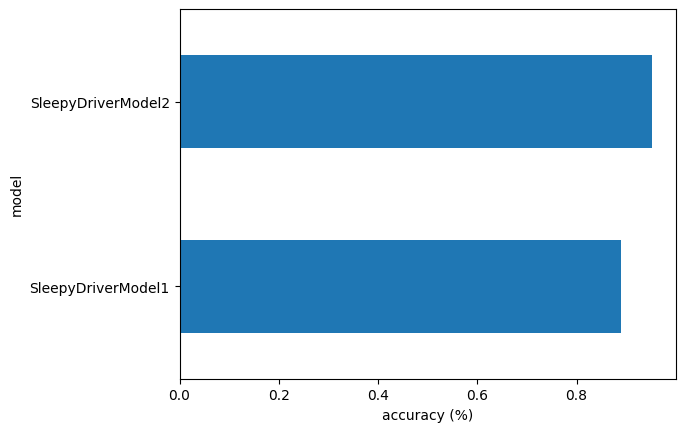

In [34]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [35]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    predictions = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_prob = model(sample)
            pred = (pred_prob > 0.5).float()
            predictions.append(pred.cpu())

    return torch.stack(predictions).squeeze()

In [36]:
random.seed(RANDOM_SEED)

test_samples = []
test_labels = []
for sample, label in random.sample(list(test_set), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 96, 128])
Test sample label: 1 (Opened)


In [37]:
# Make predictions on test samples with model 2
pred_probs = make_predictions(model=model_2, data=test_samples)
pred_classes = [int(pred) for pred in pred_probs]

test_labels, pred_classes

([1, 0, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 1, 0, 1, 0, 0, 1])

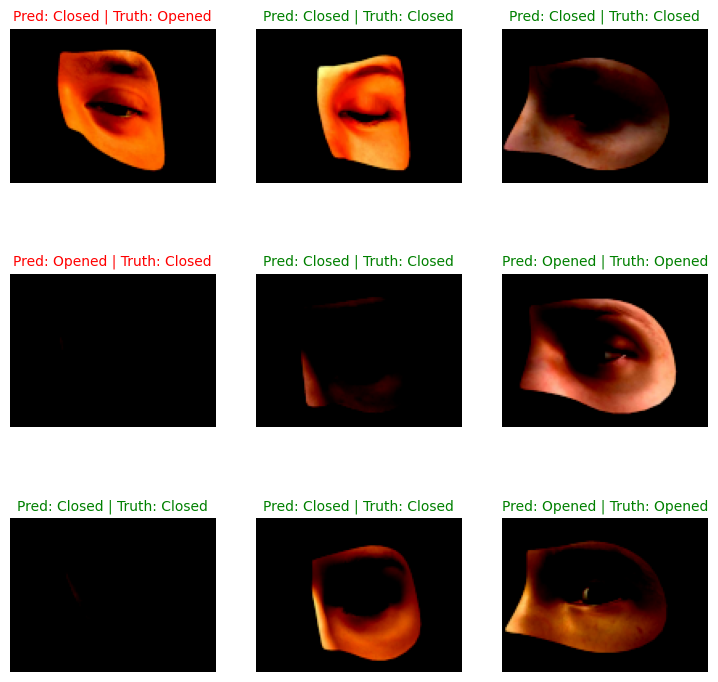

In [38]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0))

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

<center><h1>$$\text{** Confusion Matrix **}$$</h1></center>

In [39]:
# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_prob = model_2(X)
    y_pred = (y_prob > 0.5).int()
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds).squeeze()

Making predictions:   0%|          | 0/79 [00:00<?, ?it/s]

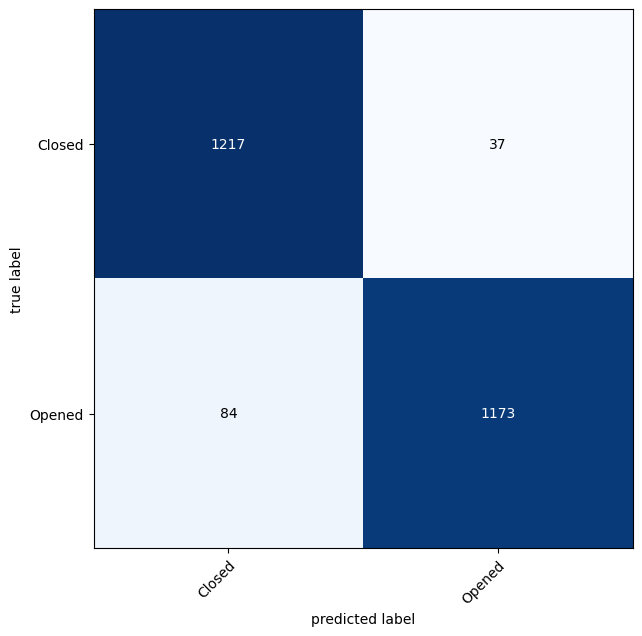

In [42]:
confmat = ConfusionMatrix(num_classes=2, task='binary')
confmat_tensor = confmat(preds=y_pred_tensor, target=torch.tensor(test_targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

<center><h1>$$\text{** Saving Model **}$$</h1></center>

In [43]:
# https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "sleepy_driver_detection_pretrained.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),  f=MODEL_SAVE_PATH)

Saving model to: models/sleepy_driver_detection_pretrained.pth


<center><h1>$$\text{** The End **}$$</h1></center>